Import libaries

In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

Data loading and preprocessing

In [23]:
def clean_Q2(q2):
    """
    Clean column Q2 in csv file, converting to all numerical discrete values.
    Handles:
    - Numerical values (e.g., "5", "6.0")
    - Ranges (e.g., "4-6")
    - Textual descriptions (e.g., "around 3")
    - Spelled-out numbers (e.g., "three")
    - Ingredient lists (e.g., "bread, meat, cheese")
    - Multi-line ingredient lists (e.g., "I would expect it to contain:\n* Bread\n* Cheese")
    - #NAME? and other non-numeric values
    """
    # Handle NaN values
    if pd.isna(q2):
        return pd.NA
    
    # Convert to string if not already
    q2 = str(q2).strip()
    
    # Handle "I don't know" or similar cases
    if '#NAME?' in q2 or 'don\'t know' in q2.lower() or 'dont know' in q2.lower() or 'no idea' in q2.lower():
        print(f"Skipping Q2 value: {q2}")
        return pd.NA
    
    # Handle ranges like "4-6" or "5 to 7"
    if '-' in q2 or 'to' in q2 or '~' in q2:
        parts = q2.replace('to', '-').replace('~', '-').split('-')
        if len(parts) == 2 and parts[0].strip().replace('.', '', 1).isdigit() and parts[1].strip().replace('.', '', 1).isdigit():
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return int((low + high) // 2)  # Return the floored average
        
    # Handle single numbers (integers or floats)
    if q2.replace('.', '', 1).isdigit():  # Check if it's a number (including floats)
        return int(float(q2))  # Convert to float first, then to integer

    # Handle textual descriptions like "around 5" or "about 3"
    textual_indicators = ["around", "about", "approximately", "~"]
    for indicator in textual_indicators:
        if indicator in q2.lower():
            parts = q2.split()
            for part in parts:
                if part.replace('.', '', 1).isdigit():  # Check if part is a number (including floats)
                    return int(float(part))  # Convert to float first, then to integer
    
    # Handle cases where the number is spelled out (e.g., "three")
    spelled_out_numbers = {
        'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
        'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10
    }
    for word, num in spelled_out_numbers.items():
        if word in q2.lower():
            return num
    
    # Handle ingredient lists
    # Check if the text looks like a list of ingredients (may be an issue for those who answered in sentences)
    if ',' in q2 or '\n' in q2 or ' and ' in q2.lower():
        lines = q2.split('\n')
        ingredients = []
        for line in lines:
            line = line.replace('*', '').replace('-', '').replace('•', '').strip()
            if line:
                parts = [part.strip() for part in line.replace(' and ', ',').split(',')]
                ingredients.extend([part for part in parts if part])
        unique_ingredients = set(ingredients)
        return len(unique_ingredients)
    
    # If no number or ingredients are found, return 'n/a'
    print(f"Could not parse Q2 value: {q2}")
    return pd.NA

def one_hot_encode(response_str, categories):
    result = np.zeros(len(categories))
    if isinstance(response_str, str):  # Check if it's a string (not NaN)
        selections = response_str.split(',')
        for i, category in enumerate(categories):
            if category in selections:
                result[i] = 1
    return result

def clean_data(df):
    """
    Clean and format the data in the dataframe
    """
    q1_label = "Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)"
    q2_label = "Q2: How many ingredients would you expect this food item to contain?"
    q3_label = "Q3: In what setting would you expect this food to be served? Please check all that apply"
    q4_label = "Q4: How much would you expect to pay for one serving of this food item?"
    q5_label = "Q5: What movie do you think of when thinking of this food item?"
    q6_label = "Q6: What drink would you pair with this food item?"
    q7_label = "Q7: When you think about this food item, who does it remind you of?"
    q8_label = "Q8: How much hot sauce would you add to this food item?"
    
    # Categorical Feature categories
    Q3_categories = ["Week day lunch", "Week day dinner", "Weekend lunch", "Weekend dinner", "At a party", "Late night snack"]
    Q6_categories = [
        "soda", "other", "tea", "alcohol", "water", "soup", "juice", "milk", 
        "unknown", "smoothie", "asian alcohol", "asian pop", "milkshake"
    ]
    Q7_categories = ["Parents", "Siblings", "Friends", "Teachers", "Strangers"]
    Q8_categories = ["None", "A little (mild)", "A moderate amount (medium)", "A lot (hot)", "I will have some of this food item with my hot sauce"]

    # Clean Q2
    # df['Q2'] = df[q2_label].apply(clean_Q2)

    # Convert cleaned to numeric
    # df['Q2'] = pd.to_numeric(df['Q2'], errors='coerce')

    # Extract columns for Q3, Q6, Q7, and Q8
    q3 = df[q3_label]
    q6 = df[q6_label]
    q7 = df[q7_label]
    q8 = df[q8_label]

    # One hot encode Q3, Q6, and Q7
    q3 = np.array([one_hot_encode(response, Q3_categories) for response in q3])
    q6 = np.array([one_hot_encode(response, Q6_categories) for response in q6])
    q7 = np.array([one_hot_encode(response, Q7_categories) for response in q7])

    # Create new columns for Q3, Q6, and Q7
    for i, category in enumerate(Q3_categories):
        df[category] = q3[:, i]
    for i, category in enumerate(Q6_categories):
        df[category] = q6[:, i]
    for i, category in enumerate(Q7_categories):
        df[category] = q7[:, i]

    # Convert Q8 to ordinal scale (0, 1, 2, 3, 4)
    ordinal_mapping = {category: idx for idx, category in enumerate(Q8_categories)}
    df['Q8'] = df[q8_label].map(ordinal_mapping)

    df = df.rename(columns={q4_label: 'Q4'})
    # Remove dollar signs from Q4
    df["Q4"] = df["Q4"].str.replace("$", "")

    # Drop original categorical columns
    df = df.drop(columns=[
        q3_label, q6_label, q7_label, q8_label
    ])

    # Change labels of Q1, Q2, and Q4
    df = df.rename(columns={q1_label: 'Q1', q2_label: 'Q2', q4_label: 'Q4'})
    
    # Make sure its an integer
    df['Q1'] = df['Q1'].astype(int, errors='ignore')
    df['Q2'] = df['Q2'].astype(int, errors='ignore')
    df['Q4'] = df['Q4'].astype(int, errors='ignore')

    return df


def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model's accuracy without using the torch library.
    """
    # Get predictions from the model
    predicted = model.predict(X_test)
    
    # Calculate the number of correct predictions
    correct = (predicted == y_test).sum()
    
    # Calculate accuracy
    accuracy = correct / len(y_test)
    
    return accuracy


In [24]:
df = pd.read_csv('../data/cleaned_data.csv')

df = clean_data(df)

<ipython-input-23-1d7b2e19ad29>:134: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["Q4"] = df["Q4"].str.replace("$", "")


### Model Building: Forward Pass

In [25]:
def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU activation function."""
    return (x > 0).astype(float)

def softmax(z):
    """
    Compute the softmax of vector z, or row-wise for a matrix z.
    For numerical stability, subtract the maximum logit value from each
    row prior to exponentiation (see above).

    Parameters:
        `z` - a numpy array of shape (K,) or (N, K)

    Returns: a numpy array with the same shape as `z`, with the softmax
        activation applied to each row of `z`
    """
    exp_z= np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z/ np.sum(exp_z, axis=1, keepdims=True)

class FoodNeuralNetwork(object):
    def __init__(self, num_features=128*20, num_hidden=100, num_classes=128):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        # information about the model architecture
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes

        # weights and biases for the first layer of the MLP
        self.W1 = np.zeros([num_hidden, num_features])
        self.b1 = np.zeros([num_hidden])

        # weights and biases for the second layer of the MLP
        self.W2 = np.zeros([num_classes, num_hidden])
        self.b2 = np.zeros([num_classes])

        # initialize the weights and biases
        self.initializeParams()

        # set all values of intermediate variables (to be used in the
        # forward/backward passes) to None
        self.cleanup()

    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.W1 = np.random.normal(0, 2/self.num_features, self.W1.shape)
        self.b1 = np.random.normal(0, 2/self.num_features, self.b1.shape)
        self.W2 = np.random.normal(0, 2/self.num_hidden, self.W2.shape)
        self.b2 = np.random.normal(0, 2/self.num_hidden, self.b2.shape)

    def forward(self, X):
        """
        Compute the forward pass to produce prediction for inputs.

        Parameters:
            `X` - A numpy array of shape (N, self.num_features)

        Returns: A numpy array of predictions of shape (N, self.num_classes)
        """
        return do_forward_pass(self, X) # To be implemented below

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return do_backward_pass(self, ts) # To be implemented below

    def loss(self, ts):
        """
        Compute the average cross-entropy loss, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return np.sum(-ts * np.log(self.y)) / ts.shape[0]

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters of this model.

        Parameters:
            `alpha` - A number representing the learning rate
        """
        self.W1 = self.W1 - alpha * self.W1_bar
        self.b1 = self.b1 - alpha * self.b1_bar
        self.W2 = self.W2 - alpha * self.W2_bar
        self.b2 = self.b2 - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        # To be filled in during the forward pass
        self.N = None # Number of data points in the batch
        self.X = None # The input matrix
        self.m = None # Pre-activation value of the hidden state, should have shape
        self.h = None # Post-RELU value of the hidden state
        self.z = None # The logit scores (pre-activation output values)
        self.y = None # Class probabilities (post-activation)
        # To be filled in during the backward pass
        self.z_bar = None # The error signal for self.z2
        self.W2_bar = None # The error signal for self.W2
        self.b2_bar = None # The error signal for self.b2
        self.h_bar = None  # The error signal for self.h
        self.m_bar = None # The error signal for self.z1
        self.W1_bar = None # The error signal for self.W1
        self.b1_bar = None # The error signal for self.b1


def do_forward_pass(model, X):
    """
    Compute the forward pass to produce prediction for inputs.

    This function also keeps some of the intermediate values in
    the neural network computation, to make computing gradients easier.

    For the ReLU activation, you may find the function `np.maximum` helpful

    Parameters:
        `model` - An instance of the class MLPModel
        `X` - A numpy array of shape (N, model.num_features)

    Returns: A numpy array of predictions of shape (N, model.num_classes)
    """
    model.N = X.shape[0]
    model.X = X
    # X = (8, 10)
    # W1 = (20, 10)
    model.m = X.dot(model.W1.T) + model.b1 # TODO - the hidden state value (pre-activation)
    model.h = np.maximum(0, model.m) # TODO - the hidden state value (post ReLU activation)
    model.z = model.h.dot(model.W2.T) + model.b2  # TODO - the logit scores (pre-activation)
    model.y = softmax(model.z) # TODO - the class probabilities (post-activation)
    return model.y

def do_backward_pass(model, ts):
    """
    Compute the backward pass, given the ground-truth, one-hot targets.

    You may assume that `model.forward()` has been called for the
    corresponding input `X`, so that the quantities computed in the
    `forward()` method is accessible.

    The member variables you store here will be used in the `update()`
    method. Check that the shapes match what you wrote in Part 2.

    Parameters:
        `model` - An instance of the class MLPModel
        `ts` - A numpy array of shape (N, model.num_classes)
    """
    model.z_bar = (model.y - ts) / model.N
    model.W2_bar = model.z_bar.T.dot(model.h)
    model.b2_bar = np.sum(model.z_bar, axis=0)
    model.h_bar = model.z_bar.dot(model.W2)
    model.m_bar = model.h_bar * (model.m > 0)
    model.W1_bar = model.m_bar.T.dot(model.X)
    model.b1_bar = np.sum(model.m_bar, axis=0)

In [26]:
def train_sgd(model, X_train, t_train,
              alpha=0.1, n_epochs=0, batch_size=100,
              X_valid=None, t_valid=None,
              w_init=None, plot=True):
    '''
    Given `model` - an instance of MLPModel
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `alpha` - the learning rate.
                    From our experiments, it appears that a larger learning rate
                    is appropriate for this task.
          `n_epochs` - the number of **epochs** of gradient descent to run
          `batch_size` - the size of each mini batch
          `X_valid` - the data matrix to use for validation (optional)
          `t_valid` - the target vector to use for validation (optional)
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
          `plot` - whether to track statistics and plot the training curve

    Solves for model weights via stochastic gradient descent,
    using the provided batch_size.

    Return weights after `niter` iterations.
    '''
    def make_onehot(indicies, total=128):
        I = np.eye(total)
        return I[indicies]
    # as before, initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    train_loss = [] # for the current minibatch, tracked once per iteration
    valid_loss = [] # for the entire validation data set, tracked once per epoch

    # track the number of iterations
    niter = 0

    # we will use these indices to help shuffle X_train
    N = X_train.shape[0] # number of training data points
    indices = list(range(N))

    for e in range(n_epochs):
        random.shuffle(indices) # for creating new minibatches

        for i in range(0, N, batch_size):
            if (i + batch_size) > N:
                # At the very end of an epoch, if there are not enough
                # data points to form an entire batch, then skip this batch
                continue

            indices_in_batch = indices[i: i+batch_size]
            X_minibatch = X_train[indices_in_batch, :]
            t_minibatch = make_onehot(t_train[indices_in_batch], model.num_classes)

            # gradient descent iteration
            model.cleanup()
            model.forward(X_minibatch)
            model.backward(t_minibatch)
            model.update(alpha)

            if plot:
                # Record the current training loss values
                train_loss.append(model.loss(t_minibatch))
            niter += 1

        # compute validation data metrics, if provided, once per epoch
        if plot and (X_valid is not None) and (t_valid is not None):
            model.cleanup()
            model.forward(X_valid)
            valid_loss.append((niter, model.loss(make_onehot(t_valid, model.num_classes))))

    if plot:
        plt.title("SGD Training Curve Showing Loss at each Iteration")
        plt.plot(train_loss, label="Training Loss")
        if (X_valid is not None) and (t_valid is not None): # compute validation data metrics, if provided
            plt.plot([iter for (iter, loss) in valid_loss],
                     [loss for (iter, loss) in valid_loss],
                     label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        print("Final Training Loss:", train_loss[-1])
        if (X_valid is not None) and (t_valid is not None):
            print("Final Validation Loss:", valid_loss[-1])

In [27]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split data into training and testing sets.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Labels array.
        test_size (float): Proportion of the dataset to include in the test split (default 0.2).
        random_state (int): Seed for reproducibility (default None).

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    if random_state is not None:
        np.random.seed(random_state)  # Set random seed for reproducibility

    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Apply the shuffled indices to X and y
    X = X[indices]
    y = y[indices]

    # Compute the split index
    split_idx = int(X.shape[0] * (1 - test_size))

    # Split the data
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    X_train = X_train.astype(int)
    X_test = X_test.astype(int)

    return X_train, X_test, y_train, y_test

In [28]:
feature_columns = [
"Q1",
"Q2",
"Q4",
# "Q5: What movie do you think of when thinking of this food item?", Removing for now
"Q8",
"Week day lunch",
"Week day dinner",
"Weekend lunch",
"Weekend dinner",
"At a party",
"Late night snack",
"soda",
"other",
"tea",
"alcohol",
"water",
"soup",
"juice",
"milk",
"unknown",
"smoothie",
"asian alcohol",
"asian pop",
"milkshake",
"Parents",
"Siblings",
"Friends",
"Teachers",
"Strangers"
]

# summarize df
df = df[feature_columns + ['Label']]

features = df[feature_columns].fillna(0).values
X = df[feature_columns].fillna(0).values
y = df['Label'].map({'Pizza': 0, 'Shawarma': 1, 'Sushi': 2}).values  # Convert labels to integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

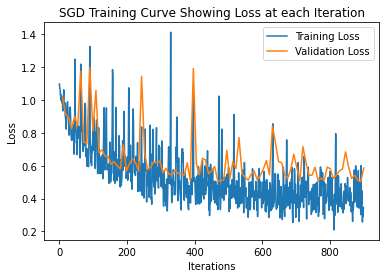

Final Training Loss: 0.3462834210678304
Final Validation Loss: (900, 0.5853373276942396)


In [29]:
model = FoodNeuralNetwork(num_features=X_train.shape[1], num_hidden=100, num_classes=3)

# accuracy = evaluate_model(model, X_test, y_test)
# print(f'Test Accuracy: {accuracy:.4f}')

train_sgd(model, X_train, y_train, alpha=0.1, n_epochs=100, batch_size=100, X_valid=X_test, t_valid=y_test)